## Chapter 9

Fastbook walkthrough.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bluebook-for-bulldozers/Valid.7z
/kaggle/input/bluebook-for-bulldozers/Valid.zip
/kaggle/input/bluebook-for-bulldozers/Train.zip
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv
/kaggle/input/bluebook-for-bulldozers/median_benchmark.csv
/kaggle/input/bluebook-for-bulldozers/Valid.csv
/kaggle/input/bluebook-for-bulldozers/Machine_Appendix.csv
/kaggle/input/bluebook-for-bulldozers/random_forest_benchmark_test.csv
/kaggle/input/bluebook-for-bulldozers/Data Dictionary.xlsx
/kaggle/input/bluebook-for-bulldozers/ValidSolution.csv
/kaggle/input/bluebook-for-bulldozers/Test.csv
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.zip
/kaggle/input/bluebook-for-bulldozers/TrainAndValid.7z
/kaggle/input/bluebook-for-bulldozers/Train.7z


In [2]:
from fastai.tabular.all import Path

In [3]:
path = Path('../input/bluebook-for-bulldozers')

### The data

Its a good practice to give `low_memory = false` asit sis enabled by default,and can cause continuity changes later.

In [4]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [5]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

Ordinal columns ,refers to columns containing strings or similar but where the strings have a natural ordering, like productSize here.

In [6]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [7]:
# we can tell Pandas for a suitable ordering like

sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [8]:
df['ProductSize'] = df['ProductSize'].astype('category')
print(df['ProductSize'])
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
print(df['ProductSize'])

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']
0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']


In [9]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

The most important data is one that we want to predict. The dependent variable

In [10]:
dep_var = 'SalePrice'

HereKaggle tells you what metric to use, we use root mean squared log error (RMSLE) between actual and predicted auction prices. 

In [11]:
df[dep_var] = np.log(df[dep_var])

### Decision Tree ensembles 
After each question the data at that part of the tree is split between a yes and a no branch

### Rudimentary deision tree from scratch

This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. But what good is this? The goal of our model is to predict values for items, not to assign them into groups from the training dataset. The value is that we can now assign a prediction value for each of these groups—for regression, we take the target mean of the items in the group.

Let's consider how we find the right questions to ask. Of course, we wouldn't want to have to create all these questions ourselves—that's what computers are for! The basic steps to train a decision tree can be written down very easily:

1. Loop through each column of the dataset in turn.
1. For each column, loop through each possible level of that column in turn.
1. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
1. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
1. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
1. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
1. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.

Although this is an easy enough algorithm to implement yourself (and it is a good exercise to do so), we can save some time by using the implementation built into sklearn.

First, however, we need to do a little data preparation.

In [12]:
# my attempt at above algorithm
# https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/

# picking categorical and non categorical
# https://stackoverflow.com/questions/35826912/what-is-a-good-heuristic-to-detect-if-a-column-in-a-pandas-dataframe-is-categori
likely_cat = {}
for i in df.columns:
    #print(i)
    likely_cat[i] = 1.*df[i].nunique()/df[i].count() < 0.05 
    
# also handled by cont_cat_split

In [13]:
likely_cat

# these are columns that mightbe categorical

{'SalesID': False,
 'SalePrice': True,
 'MachineID': False,
 'ModelID': True,
 'datasource': True,
 'auctioneerID': True,
 'YearMade': True,
 'MachineHoursCurrentMeter': False,
 'UsageBand': True,
 'saledate': True,
 'fiModelDesc': True,
 'fiBaseModel': True,
 'fiSecondaryDesc': True,
 'fiModelSeries': True,
 'fiModelDescriptor': True,
 'ProductSize': True,
 'fiProductClassDesc': True,
 'state': True,
 'ProductGroup': True,
 'ProductGroupDesc': True,
 'Drive_System': True,
 'Enclosure': True,
 'Forks': True,
 'Pad_Type': True,
 'Ride_Control': True,
 'Stick': True,
 'Transmission': True,
 'Turbocharged': True,
 'Blade_Extension': True,
 'Blade_Width': True,
 'Enclosure_Type': True,
 'Engine_Horsepower': True,
 'Hydraulics': True,
 'Pushblock': True,
 'Ripper': True,
 'Scarifier': True,
 'Tip_Control': True,
 'Tire_Size': True,
 'Coupler': True,
 'Coupler_System': True,
 'Grouser_Tracks': True,
 'Hydraulics_Flow': True,
 'Track_Type': True,
 'Undercarriage_Pad_Width': True,
 'Stick_Leng

In [14]:
len(df)

412698

In [15]:
import math

# 1 level of dcision tree split 
# with randomly chosen 1 category

# looping through each column
for i in df.columns:
    # looping through levels
    #print("levels for " , i)
    #print(df[i].nunique())
    
    # splitting into groups
    if(df[i].dtype.kind in 'biufc' and df[i].nunique() > 20):
        # it means that the value is continous
        print(" FOR CONTINOUS ", i)
        print(" SPLIT AT ", df[i].mean())
        split_mean = df[i].mean()
        
        # splitting dataframe based on df[i].mean()
        df_left = df[df[i] < split_mean]
        df_right = df[df[i] > split_mean]
        
        print(" SALEPRICE FOR LEFT NODE ", df_left[dep_var].mean())
        print(" SALEPRICE FOR RIGHT NODE ", df_right[dep_var].mean())
        print(" ACTUAL SALEPRICE FOR NODE ", df[dep_var].mean())
        
        print("\n")
        
    else:
        # it means that the value is categorical
        print(" FOR CATEGORICAL ", i)
        # lets split at random unique column
        print(" SPLIT AT ", df[i].unique()[math.floor(len(df[i].unique())/2)])
        split_cat =  df[i].unique()[math.floor(len(df[i].unique())/2)]
        
        df_cat = df[df[i] == split_cat]
        print(" SALEPRICE FOR SPLIT NODE ", df_cat[dep_var].mean())
        print(" ACTUAL SALEPRICE FOR NODE ", df[dep_var].mean())
        
        print("\n")
    

# we are not doing it recursively nor looping through all columns
# but seems like it gives a better understanding about what decision tree does

 FOR CONTINOUS  SalesID
 SPLIT AT  2011161.1636402407
 SALEPRICE FOR LEFT NODE  10.076275955914355
 SALEPRICE FOR RIGHT NODE  10.172994086388991
 ACTUAL SALEPRICE FOR NODE  10.105977494816463


 FOR CONTINOUS  SalePrice
 SPLIT AT  10.105977494816463
 SALEPRICE FOR LEFT NODE  9.541864040366752
 SALEPRICE FOR RIGHT NODE  10.690242628548345
 ACTUAL SALEPRICE FOR NODE  10.105977494816463


 FOR CONTINOUS  MachineID
 SPLIT AT  1230061.4366461674
 SALEPRICE FOR LEFT NODE  10.230483861142735
 SALEPRICE FOR RIGHT NODE  10.0120536266167
 ACTUAL SALEPRICE FOR NODE  10.105977494816463


 FOR CONTINOUS  ModelID
 SPLIT AT  6947.201827971059
 SALEPRICE FOR LEFT NODE  10.220034813078971
 SALEPRICE FOR RIGHT NODE  9.899152241098834
 ACTUAL SALEPRICE FOR NODE  10.105977494816463


 FOR CATEGORICAL  datasource
 SPLIT AT  149
 SALEPRICE FOR SPLIT NODE  10.144495485640897
 ACTUAL SALEPRICE FOR NODE  10.105977494816463


 FOR CONTINOUS  auctioneerID
 SPLIT AT  6.58526805956766
 SALEPRICE FOR LEFT NODE  10.

### handling dates in dataset

Since date can be treated as ordinal value, however its format presents a unique challenge. 

In fastai we convert the date into a multiple columns like holiday, day of the week, month etc. through `datepart function`

In [16]:
from fastai.tabular.all import add_datepart

In [17]:
df = add_datepart(df, 'saledate')

In [18]:
# same for test
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [19]:
[o for o in df.columns if o.startswith('sale')]

['saleWeek',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

### Using TabularPandas and TabularProc

We need to handlethe missing data and strings. Since sklearn doesnt di t out of the box we will use TabularProc , Categorify and FillMissing. 

TabularProc is like a transforms:
 but it modifies in place
 it runs everything together at once
 
 `Categorify` replaces the column with a numerical categorical column
 
 `FillMissing` replaced the missing values with the median of the column and create a new column with boolean indicated value was filled.

In [20]:
from fastai.tabular.all import Categorify, FillMissing

In [21]:
# I guess we will use it often in tabular data
procs = [Categorify, FillMissing]

TabularPandas can also help in splitting data into training and validation sets for us. You cannot randomly choose because its is a time series.

`np.where` returns theindices of all `True` values

Here we choose validation as more than 2011

In [22]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

TabularPandas is the equivalent of fastai Datasets object. TabularPandas need to be told which columns are continous and which aren't. 

In [23]:
from fastai.tabular.all import cont_cat_split, TabularPandas

In [24]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs,cat,cont, y_names=dep_var, splits=splits)

In [25]:
cont

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear']

In [26]:
len(to.train), len(to.valid)

(404710, 7988)

In [27]:
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [28]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure' ], [], y_names=dep_var, splits=splits)

In [29]:
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [30]:
to.items.head(3)['ProductGroup']
# the underlying items are all numeric

0    6
1    6
2    3
Name: ProductGroup, dtype: int8

In [31]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [32]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [33]:
try:
    to.items['ProductSize']
except Exception as e:
    print(e)

In [34]:
from fastai.tabular.all import save_pickle

In [35]:
save_pickle('to.pkl',to)

In [36]:
try:
    to = (path/'to.pkl').load()
except Exception as e:
    print(e)
    print('Am I living a lie?')

'PosixPath' object has no attribute 'load'
Am I living a lie?


In [37]:
from fastai.tabular.all import load_pickle

In [38]:
to = load_pickle('to.pkl')

In [39]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [40]:
from sklearn.tree import DecisionTreeRegressor

In [41]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [42]:
# visualising tree - https://mljar.com/blog/visualize-decision-tree/
from sklearn import tree

In [43]:
text_representation = tree.export_text(m)
print(text_representation)

|--- feature_31 <= 0.50
|   |--- feature_59 <= 1991.50
|   |   |--- value: [9.97]
|   |--- feature_59 >  1991.50
|   |   |--- feature_7 <= 4.50
|   |   |   |--- value: [10.50]
|   |   |--- feature_7 >  4.50
|   |   |   |--- value: [9.62]
|--- feature_31 >  0.50
|   |--- value: [9.21]



In [44]:
for i in to.__dir__():
    print(i)

__class__
__delattr__
__delitem__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getitem__
__gt__
__hash__
__init__
__init_subclass__
__iter__
__le__
__len__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setitem__
__setstate__
__sizeof__
__slotnames__
__str__
__subclasshook__
__weakref__
_component_attr_filter
_dbunch_type
_default
_dir
_dl_type
_new
all_col_names
all_cols
cats
conts
copy
dataloaders
decode
decode_row
iloc
loc
n_subsets
new
new_empty
partial_dataloaders
process
setup
show
subset
targ
to_device
train
transform
valid
with_cont
x_names
xs
y
ys
dataloaders
items
y_names
device
cat_names
cont_names
procs
split
_call
_do_call
_is_showable
add
add_col
c
categorify
classes
decode
decode
decodes
default
encodes
fill_missing
fill_strategy
fill_vals
fs
init_enc
loss_func
na_dict
name
order
regression_setup
setup
setup
setups
show
split_idx
split_idx
train_setup


In [45]:
print(to.x_names)

['saleWeek', 'UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls', 'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end', 'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start', 'saleElapsed', 'auctioneerID_na', 'MachineHoursCurrentMeter_na', 'SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID', 'YearMade', 'MachineHoursCu

In [46]:
to.y_names

(#1) ['SalePrice']

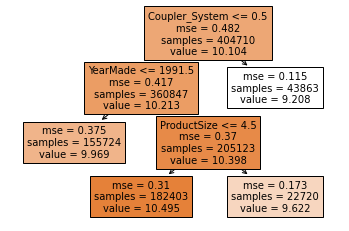

In [47]:
_ = tree.plot_tree(m,feature_names=to.x_names, class_names=to.y_names, filled=True)

Lets try and explain this tree.
The top node represents the represents the initial model before any splits were done when all data is one group.  
It predicts the value to be average of whole dataset we see the prediction of 10.10 for logof sales price with mean squared of 0.48
best split found was coupler system.

Moving down to left we see the best split is YearMade. The leaf nodes have no questions to be asked.

In [48]:
!pip install dtreeviz

     |████████████████████████████████| 49 kB 689 kB/s 
     |████████████████████████████████| 204.2 MB 29 kB/s 
     |████████████████████████████████| 198 kB 41.8 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.1.3-py3-none-any.whl size=52494 sha256=6344369e22190d26a61df09438f59c12c3326031274aa91ac49ae5fa2a3f2f9c
  Stored in directory: /root/.cache/pip/wheels/37/84/e0/ce17aa285c417cfb8a9f6dfe3e846691246fea8d6becdf9344
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612244 sha256=8dbe3abb5d2d95d31abe78e2bf38935dcf6669af347bd8c5d6e6778fb9d194c5
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built dtreeviz pyspark
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [49]:
from dtreeviz.trees import *

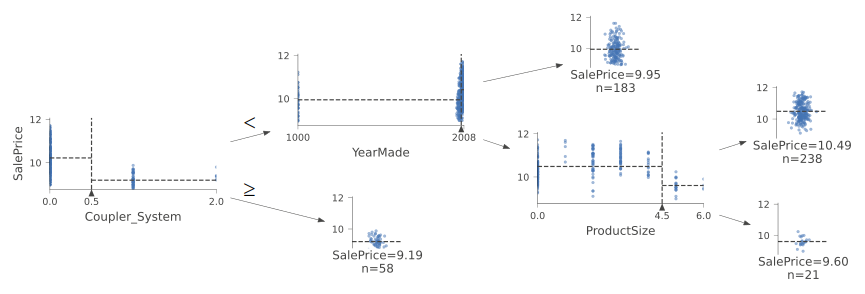

In [50]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Now we see a problem , if look at the Year made split its more like a christmas tree at the end the middle area is fully empty. so we are going to replace the values by 1950 for all Yearmade less than 1900

In [51]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']< 1900, 'Yearmade'] = 1950

In [52]:
xs['YearMade'].unique()

array([2004, 1996, 2001, 2007, 1993, 2008, 1950, 1998, 1999, 2003, 1991,
       2000, 2005, 1995, 2006, 2002, 1984, 1988, 1980, 1992, 1987, 1997,
       1971, 1978, 1989, 1985, 1979, 1976, 1994, 1982, 1990, 1974, 1968,
       1966, 1983, 1986, 1981, 1970, 1977, 1975, 1973, 1965, 1967, 2009,
       2010, 1969, 1972, 1964, 1957, 1958, 1963, 1919, 1920, 1948, 1952,
       1942, 1956, 1954, 1953, 1955, 1959, 1960, 1961, 1962, 1951, 1937,
       1949, 1947, 2012, 2011, 2014], dtype=int16)

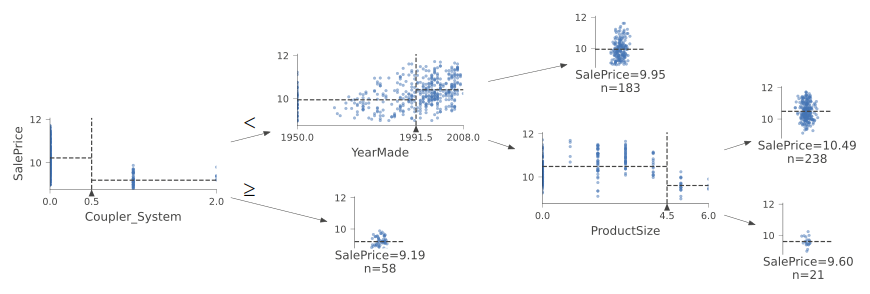

In [53]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs,y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, scale=1.6, label_fontsize=10, orientation='LR')

In [54]:
# lets make a biggertree with no stoppingcriteria

m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [55]:
# creating a funciton to checck the root mean squared error of our model

def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

In [56]:
m_rmse(m, xs,y)

# perfect (over fit) on training data

0.0

In [57]:
valid_xs = to.valid.xs
valid_y = to.valid.y

In [58]:
m_rmse(m, valid_xs, valid_y)

0.33256

In [59]:
# it might be bad

m.get_n_leaves(), len(xs)

# we got so many nodes , so ofcourse its overfitting
# lets restrict nodes to 25

(324571, 404710)

In [60]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248595, 0.268115)

In [61]:
m.get_n_leaves()

12397

In [62]:
m_rmse(m, valid_xs, valid_y)

# better but more imporvements needed

0.268115

### Categorical Variables

Categorical values are actually one of the most important feature thatn any other sometimes, and could not be avoided, so we need to one hot encode the categorical variables. 

### Random forests

Bagging predictors is a method for generating multiple versions of a predictors and using these to get an aggregated predictor.

the procedure for doing it 

1. randomly chosse asubset of your own data
1. train a model using this subset
1. Save that model then return to step 1 a few times
1. This will give you a number of trained models, take the predictions then take the average of each of these models predictions

Brieman expanded this concept to randomly choosing rows for each models training but also selected randomly from a subset of columns this is called random forest.

In defining randomforestresgressor `n_estimators` we define the number if trees we want,`max_samples` defines how many rows to sampe for each ree `max_features` for columns `min_samples_leaf` parameter limits the tree. n_job=-1 tells sklearn to use all ourCPUs to build the trees in parallel

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
def rf(xs, y, n_estimators=540, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [65]:
m = rf(xs, y)

In [66]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.169033, 0.231104)

Random forest isnt ery sensitive to the hyperparameter choices such as max_features. max_samples can often be left at its default

In [67]:
preds= np.stack([t.predict(valid_xs) for t in m.estimators_])

# m.estimators are the different random forest models

In [68]:
r_mse(preds.mean(0), valid_y)

0.231104

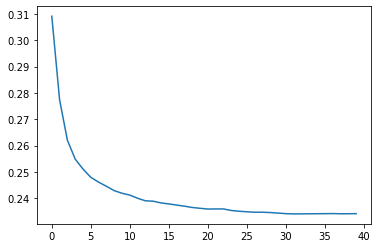

In [69]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

### Out of bag error

The performance on our validation set is worse than on our training set. OOB is a way of measuring prediction error on a different subse tof the training data.

In [70]:
r_mse(m.oob_prediction_,y)

0.207708

### Model Interpretation

These arete things to be considered in every prediction model
> How Confident are we in our predictions using a particular row of data

> For prediction with a particular row of data what were the most importatn factors and how they influenced that prediction

> which columns were strongest predictors

> which columns are redundant

> How do predictions vary

### Tree variance for confidence

confidence can be found using the considering the standard deviation 

In [71]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

(540, 7988)

In [72]:
# now we have a prediction for every tree and every auction
# getting standard deviation of all trees
preds_std = preds.std(0)

In [73]:
preds_std[:5]

#this makes moreof a diffenrece in production systme

array([0.26261146, 0.12667058, 0.10955042, 0.26701378, 0.13141004])

### Feature importance

We can use sklearns `feature_importances_`

In [74]:
def rf_feat_importance(m,df):
    return pd.DataFrame({'cols': df.columns,'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [75]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.178571
31,Coupler_System,0.122322
7,ProductSize,0.120560
8,fiProductClassDesc,0.072689
56,ModelID,0.055415
51,saleElapsed,0.050329
4,fiSecondaryDesc,0.044373
33,Hydraulics_Flow,0.037448
32,Grouser_Tracks,0.034510
2,fiModelDesc,0.032714


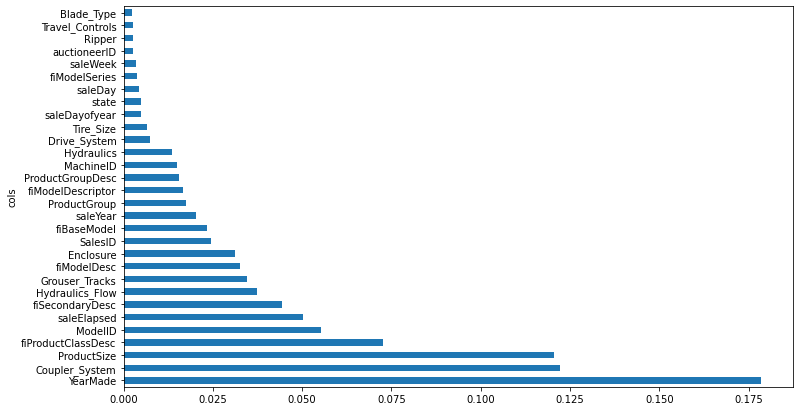

In [76]:
#heres aplot for relative importances

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

### Removing low importance Variables 

if `fi.imp` < 0.005


In [77]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [78]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [79]:
m = rf(xs_imp, y)

In [80]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp,valid_y)

(0.179681, 0.229391)

In [81]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

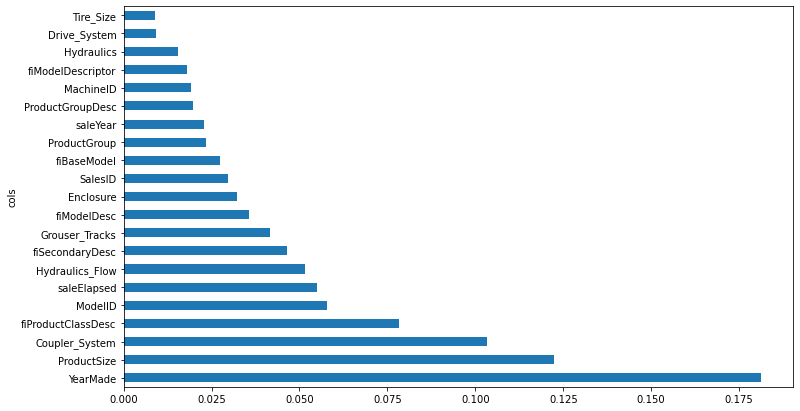

In [82]:
plot_fi(rf_feat_importance(m, xs_imp))

### Removing redundant features

In [83]:
import scipy
from scipy.cluster import hierarchy as hc


# https://www.kaggle.com/saty101/fastai-course-v4-utils

In [84]:

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

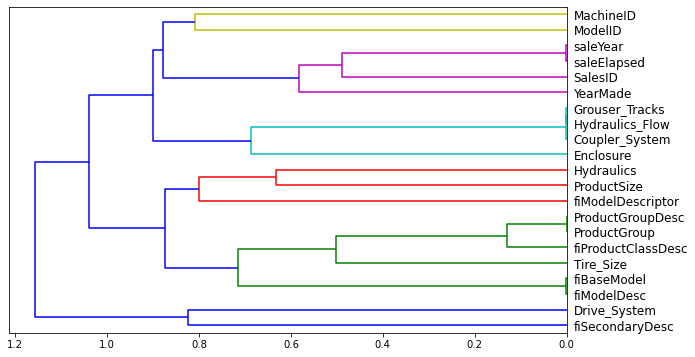

In [85]:
cluster_columns(xs_imp)

This chart shows the pair of columns that are most similar. Unsurprisingle the fields liek saleYear and saleElapsed were merged early. Similarity is determined throughrank. Lets define a function that trains the random forst on a dataset and gives the oob scorewe use  a lower max_samples and min_smaples_leaf.

In [86]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                              max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df,y)
    return m.oob_score_

In [87]:
get_oob(xs_imp)

0.8769028870386805

In [88]:
# lets remove each of our ptentially redundant variables one at a time
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8760105026338226,
 'saleElapsed': 0.8731044440157214,
 'ProductGroupDesc': 0.8780614498735902,
 'ProductGroup': 0.8776395738121334,
 'fiModelDesc': 0.8755780610033624,
 'fiBaseModel': 0.8762578954623027,
 'Hydraulics_Flow': 0.8772507181003538,
 'Grouser_Tracks': 0.8782473368234065,
 'Coupler_System': 0.8777703447269126}

In [89]:
# removing multiple variables

to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8736933184930483

In [90]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [91]:
path = Path("./")

In [92]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [93]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [94]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.181747, 0.231162)

### Partial Dependence

UNderstanding the relationship between prdictors , goood idea is to check the count the vaues er category to see howcommon eachcategory is

([<matplotlib.axis.YTick at 0x7ff51068b8d0>,
 [Text(0, 0, '#na#'),
  Text(0, 0, 'Large'),
  Text(0, 0, 'Large / Medium'),
  Text(0, 0, 'Medium'),
  Text(0, 0, 'Small'),
  Text(0, 0, 'Mini'),
  Text(0, 0, 'Compact')])

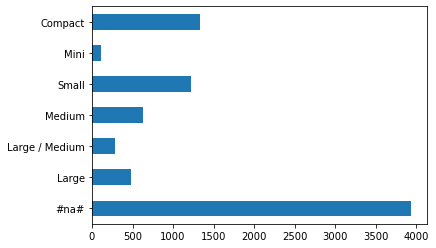

In [95]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)

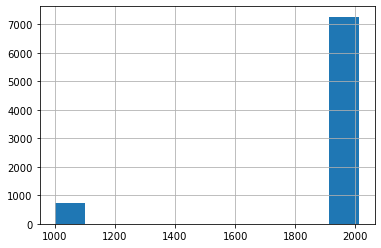

In [96]:
ax = valid_xs_final['YearMade'].hist()

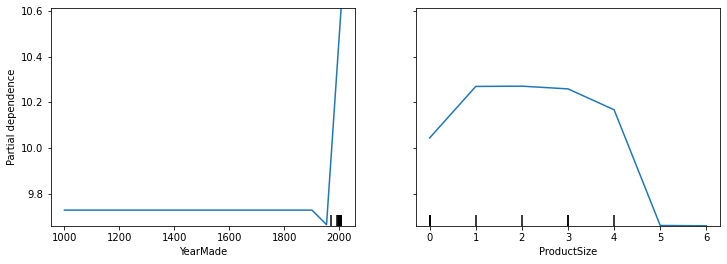

In [97]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(12,4))

plot_partial_dependence(m, valid_xs_final,['YearMade', 'ProductSize'], grid_resolution=20, ax=ax)

### Data Leakage

Happens when cause and effect is reversed. SOmething that happened after the fact is used to use as prediction identifier. Like being happy means winning. But if the data was collected after winning most people would be happy anyway. 


### Tree Interpreter 

These can help you to identify which factors influence specific predictions

In [98]:
!pip install treeinterpreter

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [99]:
!pip install waterfallcharts

  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3411 sha256=ecbcf3f85132173ab64636d958fdbd05977c576c33b27139bfba5ad42b056e18
  Stored in directory: /root/.cache/pip/wheels/4a/b2/85/9b6eda27fab2effa580c6942fb094e8536cc46e8741ec5f586
Successfully built waterfallcharts
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [100]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

this helpsin answering : For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?

This is used to see if a particular column is predicted to be expensive wy exactly is it predicted that way.

In [101]:
row = valid_xs_final.iloc[:5]

In [102]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [103]:
prediction[0], bias[0], contributions[0].sum()

(array([9.98412517]), 10.104399928005279, -0.12027475934492687)

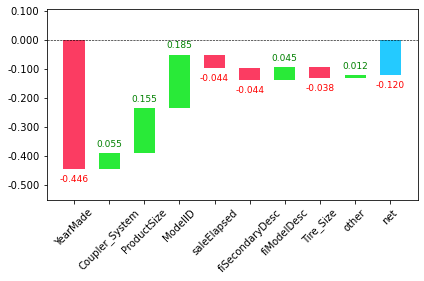

In [104]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

This is exactly the parameters that are used for predictions

### Extrapolation problem in random forests

In [105]:
np.random.seed(42)

In [106]:
from fastai.tabular.all import torch

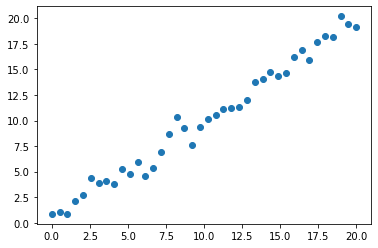

In [107]:
# lets take a simple task of makingpredictions from 40 datapoints
# showing a noisy linear relationship

x_lin = torch.linspace(0,20,steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [108]:
# we need to turn our variable to a matrix with one column

xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [109]:
x_lin[:, None].shape

# more flexible is to slice anarray with None which adds one additional unit axis

torch.Size([40, 1])

In [110]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

# we will use the first 30 rows to train the model

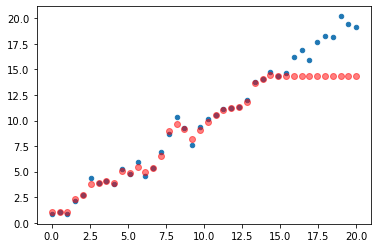

In [111]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

Why is this happening ? its because a random forest can only predict in the domain, and it is as high as it can go. SO in a datalike inflation which rises beyond the training data random forests will not work.

### Finding Out of domain data

in validation set. 

We use decision tree to see if the data is in the training set or validatio set. To see this in action lets combine our training and validation sets together create a dependent varible that represent which dataset each row comes form

In [112]:
# it is eady through using a random forest

df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]* len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.870547
10,SalesID,0.079198
0,YearMade,0.027575
13,MachineID,0.020596
4,ModelID,0.000357
9,Enclosure,0.000357


This shows that there are three columns that differ significantly berween trianingand validation sets: saleElapsed, SalesID, machineID

In [113]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231034
SalesID 0.229059
saleElapsed 0.233834
MachineID 0.229661


Lookslikewe can remove SalesID, MachinID

In [114]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)



In [115]:
m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228055

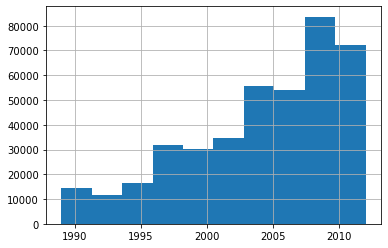

In [116]:
#another way to remove data is simply removing old data

xs['saleYear'].hist()

The result of training on this subset

In [117]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [118]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176519, 0.228151)

## Lets see if using neural network helps

In [119]:
df_nn = pd.read_csv('../input/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

using the same columns for our neural network that we did for random forest

In [120]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

1. categorical values are handles thorugh embeddings in neural network, if max_card is lower then fastai will treat the variable as categorical, embedding larger than 10,000 should only be used after youve tested wether there are better was to do so. grup the variable so we will use 9000 as out `max_card`

In [121]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

we do not want ot treat `saleElapsed` as categorical.

In [122]:
df_nn_final['saleElapsed'].head()

0    1163635200
1    1080259200
2    1077753600
3    1305763200
4    1248307200
Name: saleElapsed, dtype: object

In [123]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

We also want ot makesure it is of numeric type

In [124]:
df_nn['saleElapsed'] = df_nn['saleElapsed'].astype(int)

In [125]:
#lookingat cardinality of all categorical variables
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

There are two variables pertaining to "model" of the equipment bith with very high cardinalities suggesting that they may be redundant. Lets try removing it.

In [126]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)

In [127]:
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

# theres minimal impact so we will remove it

(0.175608, 0.228953)

In [128]:
cat_nn.remove('fiModelDescriptor')

We can create our tabular pandas the same way we created before with one significanta ddition we now need to introduce normalisation 

In [129]:
from fastai.tabular.all import Normalize

In [130]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

ValueError: Unable to coerce to Series, length must be 1: given 0

In [131]:
# since Tabular models dont require much GPU RAM we can use larger batch sizes
dls = to_nn.dataloaders(1024)

NameError: name 'to_nn' is not defined

In [132]:
y = to_nn.train.y
y.min(), y.max()

# lets look at the range of our dependent model

NameError: name 'to_nn' is not defined

We use `tabular_learner` for creating the model. we need a big model though

In [133]:
from fastai.tabular.all import tabular_learner, F

In [134]:
learn  = tabular_learner(dls, y_range=(8,12), layers=[500,250], 
                         n_out=1, loss_func=F.mse_loss)

NameError: name 'dls' is not defined

In [135]:
learn.lr_find()

NameError: name 'learn' is not defined

In [136]:
learn.fit_one_cycle(5, 1e-3)

NameError: name 'learn' is not defined

In [137]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

NameError: name 'learn' is not defined

In [138]:
learn.save('nn1')

NameError: name 'learn' is not defined

In fastai a tabular model is simply a model that takes in columns of continuos or categorical data and predicts a category. `tabular_learner` is an object of class `TabularModel`

In [139]:
#tabular_learner??

You'll see that like `collab_learner`, it first calls `get_emb_sz` to calculate appropriate embedding sizes (you can override these by using the `emb_szs` parameter, which is a dictionary containing any column names you want to set sizes for manually), and it sets a few other defaults. Other than that, it just creates the `TabularModel`, and passes that to `TabularLearner` (note that `TabularLearner` is identical to `Learner`, except for a customized `predict` method).

### Using Ensembling

lets use neural net and random forest togethor. fusion time!


One minor issue we have to be aware of is that our PyTorch model and our sklearn model create data of different types: PyTorch gives us a rank-2 tensor (i.e, a column matrix), whereas NumPy gives us a rank-1 array (a vector). `squeeze` removes any unit axes from a tensor, and `to_np` converts it into a NumPy array:

In [140]:
try:
    rf_preds = m.predict(valid_xs_time)
    ens_preds = (to_np(preds.squeeze()) + rf_preds) /2
    r_mse(ens_preds,valid_y)
except Exception as e:
    print(e)

name 'to_np' is not defined


### Boosting

Note from chapter

So far our approach to ensembling has been to use bagging, which involves combining many models (each trained on a different data subset) together by averaging them. As we saw, when this is applied to decision trees, this is called a random forest.

There is another important approach to ensembling, called boosting, where we add models instead of averaging them. Here is how boosting works:

Train a small model that underfits your dataset.
Calculate the predictions in the training set for this model.
Subtract the predictions from the targets; these are called the "residuals" and represent the error for each point in the training set.
Go back to step 1, but instead of using the original targets, use the residuals as the targets for the training.
Continue doing this until you reach some stopping criterion, such as a maximum number of trees, or you observe your validation set error getting worse.
Using this approach, each new tree will be attempting to fit the error of all of the previous trees combined. Because we are continually creating new residuals, by subtracting the predictions of each new tree from the residuals from the previous tree, the residuals will get smaller and smaller.

To make predictions with an ensemble of boosted trees, we calculate the predictions from each tree, and then add them all together. There are many models following this basic approach, and many names for the same models. Gradient boosting machines (GBMs) and gradient boosted decision trees (GBDTs) are the terms you're most likely to come across, or you may see the names of specific libraries implementing these; at the time of writing, XGBoost is the most popular.

Note that, unlike with random forests, with this approach there is nothing to stop us from overfitting. Using more trees in a random forest does not lead to overfitting, because each tree is independent of the others. But in a boosted ensemble, the more trees you have, the better the training error becomes, and eventually you will see overfitting on the validation set.

We are not going to go into detail on how to train a gradient boosted tree ensemble here, because the field is moving rapidly, and any guidance we give will almost certainly be outdated by the time you read this. As we write this, sklearn has just added a HistGradientBoostingRegressor class that provides excellent performance. There are many hyperparameters to tweak for this class, and for all gradient boosted tree methods we have seen. Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters; in practice, most people use a loop that tries a range of different hyperparameters to find the ones that work best.


### Combining embeddings with orher methods

if you first train a neural network with categorical embeddings, and then use those categorical embeddings instead of the raw categorical columns in the model. In every case, the models are dramatically improved by using the embeddings instead of the raw categories.

This is a really important result, because it shows that you can get much of the performance improvement of a neural network without actually having to use a neural network at inference time. You could just use an embedding, which is literally just an array lookup, along with a small decision tree ensemble.

These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

### Conclusion

* We have dicussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:

Random forests are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

Gradient boosting machines in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

Neural networks take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.